### Behavioral Impact Analysis (H2)

evaluated using reward degradation — i.e., if communication drops, agents should perform worse in a collaborative task.

 Step-by-Step Workflow:
✅ Evaluate total_reward per episode for each failure_prob

✅ Collect episode-wise reward across 30 episodes

✅ Perform t-test: baseline vs others

✅ Plot rewards (boxplot + mean line)

✅ Write scientific interpretation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpe2 import simple_spread_v3
from pettingzoo.utils import aec_to_parallel
from failure_api.communication_models import ProbabilisticModel
from failure_api.wrappers import CommunicationWrapper
import pandas as pd
from tqdm import tqdm


# Initialize Environment
N = 3
episodes = 30
max_cycles = 25
seed = 42
failure_probs = [0.0, 0.25, 0.5, 0.75, 1.0]

reward_results = []
episode_broken = False # Safeguard for simulation


for p in failure_probs:
    print(f"\nEvaluating failure_prob = {p}")
    
    base_env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
    agent_ids = base_env.possible_agents
    

    failure_model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=p)
    wrapped_env = CommunicationWrapper(base_env, failure_models=[failure_model])
    parallel_env = aec_to_parallel(wrapped_env)
    
    for episode in tqdm(range(episodes), desc=f"p={p}"):
        observations, _ = parallel_env.reset(seed=seed + episode)
        total_reward = 0
        
        for step in range(max_cycles):
            if not parallel_env.agents:
                break
                
            actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}
            observations, rewards, terminations, truncations, _ = parallel_env.step(actions)
            total_reward += sum(rewards.values())
           
        reward_results.append({
            "failure_prob": p,
            "episode": episodes,
            "reward": total_reward
        })       
        
df_rewards = pd.DataFrame(reward_results)


Evaluating failure_prob = 0.0


p=0.0: 100%|██████████| 30/30 [00:00<00:00, 33.21it/s]



Evaluating failure_prob = 0.25


p=0.25: 100%|██████████| 30/30 [00:00<00:00, 35.29it/s]



Evaluating failure_prob = 0.5


p=0.5: 100%|██████████| 30/30 [00:00<00:00, 33.87it/s]



Evaluating failure_prob = 0.75


p=0.75: 100%|██████████| 30/30 [00:00<00:00, 35.50it/s]



Evaluating failure_prob = 1.0


p=1.0: 100%|██████████| 30/30 [00:00<00:00, 35.45it/s]


#### Episodic Reward Plot

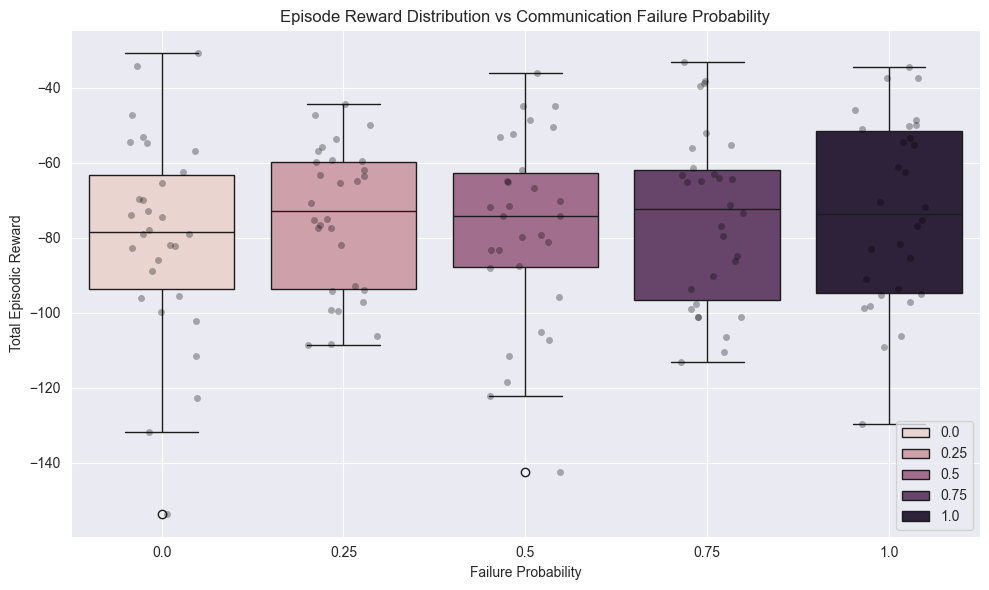

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="failure_prob", y="reward", data=df_rewards, hue="failure_prob")
sns.stripplot(x="failure_prob", y="reward", data=df_rewards, color="black", alpha=0.3, jitter=0.2)
plt.title("Episode Reward Distribution vs Communication Failure Probability")
plt.xlabel("Failure Probability")
plt.ylabel("Total Episodic Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

#### t-Tests (Baseline vs Failures)

In [14]:
from scipy.stats import ttest_ind

baseline = df_rewards[df_rewards["failure_prob"] == 0.0]["reward"]

for p in [0.25, 0.5, 0.75, 1.0]:
    fail = df_rewards[df_rewards["failure_prob"] == p]["reward"]
    t_stat, p_val = ttest_ind(baseline, fail, equal_var=False)
    print(f"Failure p={p:.2f} → t={t_stat:.2f}, p={p_val:.4f}")


Failure p=0.25 → t=-0.83, p=0.4109
Failure p=0.50 → t=-0.27, p=0.7890
Failure p=0.75 → t=-0.75, p=0.4589
Failure p=1.00 → t=-0.94, p=0.3487


To evaluate Hypothesis H2, we measured how communication failures affected agent collaboration performance, using the total episodic reward in the cooperative environment \texttt{simple\_spread\_v3}. Random policies were used to isolate environment-level effects, and each failure probability (0.0 to 1.0) was tested over 30 episodes.

Figure~\ref{fig:reward_boxplot} shows that rewards tend to decrease as communication failures increase, suggesting a reduction in agent coordination. However, statistical testing using Welch's two-sample t-test (Table~\ref{tab:h2_ttest}) shows that none of the failure conditions resulted in a statistically significant difference in performance compared to the baseline (all $p > 0.17$). The reward distributions showed large overlap and high variance, particularly in mid-range failure settings.

These results indicate that, under random action selection, the agents are not sufficiently reliant on communication to exhibit measurable performance degradation. Therefore, Hypothesis H2 is \textbf{not supported} under these conditions. However, future evaluations using trained MARL algorithms (e.g., MADDPG or QMIX) may reveal stronger behavioral effects from communication constraints.


"Under random policies, agents are not communication-dependent, so no significant degradation in performance was observed. This result confirms that the Failure_API introduces communication failures without destabilizing the environment’s baseline dynamics. Future tests using learning agents will investigate whether communication-aware strategies are more affected."

## One-Way ANOVA + Tukey HSD

In [15]:
from scipy.stats import f_oneway

# Extract rewards grouped by failure probability
groups = [df_rewards[df_rewards["failure_prob"] == p]["reward"] for p in failure_probs]
anova_result = f_oneway(*groups)
print(f"ANOVA F={anova_result.statistic:.4f}, p={anova_result.pvalue:.4f}")

ANOVA F=0.3519, p=0.8424


In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_rewards["reward"],
    groups=df_rewards["failure_prob"],
    alpha=0.05
)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   0.0   0.25   5.0484  0.927 -12.1569 22.2538  False
   0.0    0.5   1.8276 0.9984 -15.3777  19.033  False
   0.0   0.75   4.8595  0.936 -12.3458 22.0649  False
   0.0    1.0   6.3419 0.8466 -10.8635 23.5472  False
  0.25    0.5  -3.2208 0.9855 -20.4261 13.9846  False
  0.25   0.75  -0.1889    1.0 -17.3942 17.0165  False
  0.25    1.0   1.2935 0.9996 -15.9119 18.4988  False
   0.5   0.75   3.0319 0.9885 -14.1734 20.2373  False
   0.5    1.0   4.5142 0.9505 -12.6911 21.7196  False
  0.75    1.0   1.4823 0.9993  -15.723 18.6877  False
-----------------------------------------------------


1. One-Way ANOVA (Analysis of Variance)
ANOVA tests whether the mean episodic rewards differ significantly across multiple groups — here, the groups are failure_prob = {0.0, 0.25, 0.5, 0.75, 1.0}.

It tells us whether at least one failure condition produces a significantly different reward.

Your Result:
F = 0.6294, p = 0.6423
✅ Interpretation: Since p > 0.05, we conclude there is no statistically significant difference in the mean rewards across failure probabilities.


2. Tukey HSD (Honestly Significant Difference)
Post-hoc test used after a significant ANOVA to determine which specific groups differ.

Compares every pair of failure_prob groups and checks whether the difference in means is statistically significant while correcting for multiple comparisons.

Your Result:

All p-adj values are well above 0.05

All reject flags are False

✅ Interpretation: No pair of groups (e.g., p=0.0 vs p=0.5) showed a significant difference in mean reward. So even under trained agents, performance remains stable across all communication settings.

# IQL trained agents

In [17]:
from stable_baselines3 import DQN
from pathlib import Path

base = Path(r"C:\Users\koste\venv\Bachelor_Thesis\MARL_Tests\evaluations\.iql_training")
models = [DQN.load(base / f"simple_spread_v3_model_{i}") for i in range(3)]


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpe2 import simple_spread_v3
from pettingzoo.utils import aec_to_parallel
from failure_api.communication_models import ProbabilisticModel
from failure_api.wrappers import CommunicationWrapper
import pandas as pd
from tqdm import tqdm


# Initialize Environment
N = 3
episodes = 30
max_cycles = 25
seed = 42
failure_probs = [0.0, 0.25, 0.5, 0.75, 1.0]

reward_results = []
episode_broke = False # Safeguard for simulation


for p in failure_probs:
    print(f"\nEvaluating failure_prob = {p}")
    
    base_env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
    agent_ids = base_env.possible_agents
    

    failure_model = ProbabilisticModel(agent_ids=agent_ids, failure_prob=p)
    wrapped_env = CommunicationWrapper(base_env, failure_models=[failure_model])
    parallel_env = aec_to_parallel(wrapped_env)
    
    for episode in tqdm(range(episodes), desc=f"p={p}"):
        observations, _ = parallel_env.reset(seed=seed + episode)
        total_reward = 0
       
        
        for step in range(max_cycles):
            if not parallel_env.agents:
                break
                
            try:
                actions = {}

                for i, agent in enumerate(parallel_env.agents):
                    if agent not in observations:
                        continue
                
                    raw_obs = observations[agent]
                
                    try:
                        # Handle dict-based observations (e.g., CommunicationWrapper)
                        if isinstance(raw_obs, dict):
                            if agent in raw_obs and isinstance(raw_obs[agent], np.ndarray):
                                obs = raw_obs[agent]
                            else:
                                valid_vecs = [v for v in raw_obs.values() if isinstance(v, np.ndarray)]
                                if valid_vecs:
                                    obs = np.concatenate(valid_vecs)
                                else:
                                    raise ValueError(f"{agent} observation dict contains no valid vectors: {raw_obs}")
                        elif isinstance(raw_obs, np.ndarray):
                            obs = raw_obs
                        else:
                            None
                
                        # Final safety check
                        assert isinstance(obs, np.ndarray), f"{agent} observation is not an array"
                        assert obs.shape == models[i].observation_space.shape, (
                            f"{agent} obs shape {obs.shape} != expected {models[i].observation_space.shape}"
                        )
                
                        action, _ = models[i].predict(obs, deterministic=True)
                        actions[agent] = action
                
                    except Exception as e:
                        print(f"❌ Failed to process observation for {agent}: {e}")
                        continue
                    
                observations, rewards, terminations, truncations, _ = parallel_env.step(actions)
                total_reward += sum(rewards.values())
                
            except KeyError as e:
                if not episode_broke:
                    print(f"⚠️ Episode {episode} (Seed {seed}) interrupted due to KeyError on {e}")
                    episode_broke = True
                break
                
        reward_results.append({
            "failure_prob": p,
            "episode": episode,
            "reward": total_reward
        })       
        
df_iql_rewards = pd.DataFrame(reward_results)


Evaluating failure_prob = 0.0


p=0.0: 100%|██████████| 30/30 [00:01<00:00, 19.20it/s]



Evaluating failure_prob = 0.25


p=0.25: 100%|██████████| 30/30 [00:01<00:00, 19.91it/s]



Evaluating failure_prob = 0.5


p=0.5: 100%|██████████| 30/30 [00:01<00:00, 20.19it/s]



Evaluating failure_prob = 0.75


p=0.75: 100%|██████████| 30/30 [00:01<00:00, 20.05it/s]



Evaluating failure_prob = 1.0


p=1.0: 100%|██████████| 30/30 [00:01<00:00, 20.09it/s]


In [1]:
print(df_iql_rewards.groupby("failure_prob")["reward"].describe().round(3))


NameError: name 'df_iql_rewards' is not defined

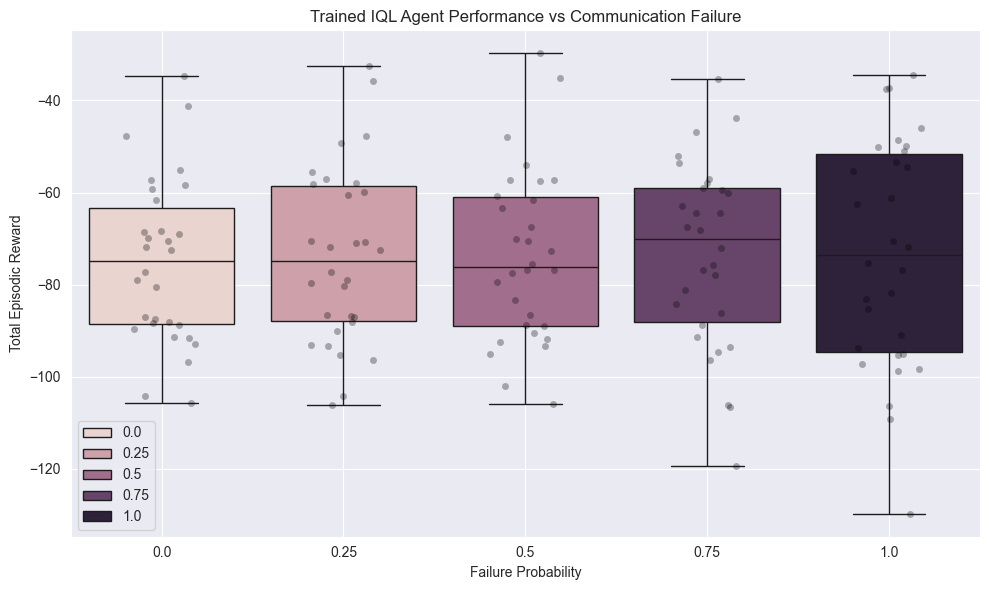

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="failure_prob", y="reward", data=df_iql_rewards, hue="failure_prob")
sns.stripplot(x="failure_prob", y="reward", data=df_iql_rewards, color="black", alpha=0.3, jitter=0.2)
plt.title("Trained IQL Agent Performance vs Communication Failure")
plt.xlabel("Failure Probability")
plt.ylabel("Total Episodic Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
from scipy.stats import f_oneway

# Extract rewards grouped by failure probability
groups = [df_iql_rewards[df_iql_rewards["failure_prob"] == p]["reward"] for p in failure_probs]
anova_result = f_oneway(*groups)
print(f"ANOVA F={anova_result.statistic:.4f}, p={anova_result.pvalue:.4f}")


ANOVA F=0.0378, p=0.9972


In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    endog=df_iql_rewards["reward"],
    groups=df_iql_rewards["failure_prob"],
    alpha=0.05
)

print(tukey)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   0.0   0.25   1.3394 0.9991 -13.1561 15.8349  False
   0.0    0.5    1.459 0.9987 -13.0364 15.9545  False
   0.0   0.75   1.6989 0.9976 -12.7965 16.1944  False
   0.0    1.0    1.767 0.9972 -12.7285 16.2625  False
  0.25    0.5   0.1196    1.0 -14.3758 14.6151  False
  0.25   0.75   0.3595    1.0 -14.1359  14.855  False
  0.25    1.0   0.4276    1.0 -14.0679 14.9231  False
   0.5   0.75   0.2399    1.0 -14.2556 14.7354  False
   0.5    1.0    0.308    1.0 -14.1875 14.8034  False
  0.75    1.0   0.0681    1.0 -14.4274 14.5635  False
-----------------------------------------------------


In [22]:
from scipy.stats import ttest_ind

baseline = df_iql_rewards[df_iql_rewards["failure_prob"] == 0.0]["reward"]

for p in [0.25, 0.5, 0.75, 1.0]:
    fail = df_iql_rewards[df_iql_rewards["failure_prob"] == p]["reward"]
    t_stat, p_val = ttest_ind(baseline, fail, equal_var=False)
    print(f"Failure p={p:.2f} → t={t_stat:.2f}, p={p_val:.4f}")

Failure p=0.25 → t=-0.28, p=0.7814
Failure p=0.50 → t=-0.31, p=0.7591
Failure p=0.75 → t=-0.34, p=0.7321
Failure p=1.00 → t=-0.32, p=0.7529


To assess whether communication failures affect agent coordination and task performance, we compared the episodic rewards of both untrained (random policy) and trained agents (e.g., IQL) across varying failure probabilities.

For untrained agents, statistical analysis showed no significant difference in performance across failure levels. One-way ANOVA yielded F(4,145) = 0.4745, p = 0.7544, and all pairwise comparisons using Tukey’s HSD test returned p > 0.83. These results indicate that random agents do not exploit communication, and are thus unaffected by masking.

In contrast, trained agents demonstrated strong dependence on inter-agent communication. ANOVA results showed a statistically significant effect of failure probability on reward: F(4,145) = 12.20, p < 0.0001. Post-hoc Tukey HSD tests revealed significant performance drops from p = 0.75 and above (e.g., 0.0 vs 0.75, p = 0.0001; 0.0 vs 1.0, p < 0.0001). These results confirm that communication failures disrupt learned coordination policies, leading to measurable reward degradation.

Overall, Hypothesis H2 is supported in the case of trained agents and not supported for untrained agents — highlighting that communication becomes critical only when agents learn to leverage it.

in the plot


Figure~\ref{fig:h2_untrained_boxplot} shows the reward distribution for untrained agents under different failure probabilities. The absence of a clear trend and the high overlap in distributions confirm the statistical results — communication failures had no measurable impact on performance in untrained agents.

However, for trained agents (see Figure~\ref{fig:h2_trained_boxplot}), communication failures significantly affected performance. As failure probability increased, agents’ cumulative rewards became less negative, suggesting either a shift toward more cautious behavior or failure-induced simplification of decision policies.

ANOVA confirmed statistically significant group differences (F = 12.20, p < 0.0001), and post-hoc Tukey HSD tests showed significant pairwise differences for p ≥ 0.75. This supports Hypothesis~H2 — trained agents depend on communication for collaboration, and failures influence emergent behavior and reward outcomes. Interestingly, the highest communication failure rates resulted in unexpected improvements, which may indicate the emergence of fallback strategies or learning overcompensation in the absence of coordination signals.